<a href="https://colab.research.google.com/github/Brian-Clough/case_studies/blob/main/mozambique_biomass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Technical challenge: Estimating total biomass for two concessions in Mozambique
Brian J. Clough, PhD

*February 2026*

##Introduction
This notebook contains a walkthrough biomass analysis for two concessions in Mozambique.

To allow for easy reproducibility I will present the full workflow, beginning with the raw plot and concession boundary data, and proceeding through prediction of total aboveground biomass (Mt/ha) for each concession.

As the analysis proceeds, I will comment on my rationale for key analytical choices. This document is meant to be a demonstration of the typical workflow I would use for this context, rather than a production-ready analysis. As such, I will also highlight places where additional model comparison, etc. may be undertaken given additional resources, data, and/or more local knowledge of the ecosystem and project site.

##Analysis overview
The analysis is presented in four sections:


*  Cleaning and preparing the raw inventory data
*  Selection of an aboveground biomass model and generation of stem and plot level total aboveground biomass estimates
* Imagery selection and post-stratification of the plot data
* Fitting a plot-level model and generating posterior distributions of concession-level aboveground biomass

##How to run this notebook
This notebook is setup to run in Google Colab, end-to-end in a new runtime environment. All packages necessary to replicate the analysis will be installed below. You will need a Google account to run it in Colab. I will also provide a copy of the notebook if you wish to run on a local machine, though some additional setup steps will likely be required.

I used Google Earth Engine's API to access imagery data. To run these elements of the notebook, you will need to link the API to a Google cloud project (the `project_id` object in the second code chunk of the notebook). You can either create your own project in the [Google Cloud console](https://console.cloud.google.com) or e-mail me at bclough84@gmail.com and I will grant permission to the project referenced below.

Please let me know if you run into any issues reproducing the analysis, or if you have any questions about the work. Thank you and let's get started!

We will first install and import the packages we need. If you're running in Colab all of these will already be installed in a new Runtime, with the exception of pystan, a package for calling [Stan](https://mc-stan.org/) from a python environment. So, we will have to install that first.


In [1]:

!pip install pystan


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.9 MB/s eta 0:00:00


Now import the packages we will use for the analysis.

In [2]:
import os
import ee
import folium
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import geemap
import xarray as xr
import numpy as np
import re
import stan

# Authenticate & connect to Google Earth Engine
# Note you will be asked to grant access to your Google account in a separate tab
project_id = 'mozambique-biomass' #Replace with your own cloud project ID or e-mail Brian for access to this one.
ee.Authenticate()
ee.Initialize(project=project_id)


## Part I: Data cleaning and processing
We begin by importing the raw plot data and preparing it for analysis. Initial inspection showed that species was recorded in local languages, possibly spanning multiple dialects, with some mapping to latin names. The inventory data contain many multistem trees. There are separate diameter/height measurements for each stem, so these can be handled separately.

I wish to note that without details on sampling protocol I had to make a few assumptions to prepare analysis-ready data. I will highlight these as appropriate.

**Import the data**

First, let's pull in the raw data files.

In [3]:
!wget -P /tmp/ https://github.com/Brian-Clough/case_studies/raw/main/data/mozambique_bounds.gpkg
!wget -P /tmp/ "https://github.com/Brian-Clough/case_studies/raw/main/data/LF_BIOMASS SURVEY_ITclean-FULL.xlsx"
!wget -P /tmp/ "https://github.com/Brian-Clough/case_studies/raw/main/data/MPM_BIOMASS SURVEY_ITclean-FULL.xlsx"


bounds_gdf = gpd.read_file('/tmp/mozambique_bounds.gpkg', layer='project_mozambique')

#Convert bounds to EE object for visualization
bounds_ee = geemap.gdf_to_ee(bounds_gdf)

--2026-02-27 22:59:39--  https://github.com/Brian-Clough/case_studies/raw/main/data/mozambique_bounds.gpkg
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Brian-Clough/case_studies/main/data/mozambique_bounds.gpkg [following]
--2026-02-27 22:59:40--  https://raw.githubusercontent.com/Brian-Clough/case_studies/main/data/mozambique_bounds.gpkg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 176128 (172K) [application/octet-stream]
Saving to: ‘/tmp/mozambique_bounds.gpkg’

mozambique_bounds.g 100%[===================>] 172.00K  --.-KB/s    in 0.009s  

2026-02-27 22:59:40 (17.8 MB/s) - ‘/tmp/mozamb

We'll use the mapping tools from the `geemap` package to visualize and conduct exploratory data analysis. These are somewhat limited in their graphical control, etc. but are convenient when we want to visualize a mix of earth engine objects & other spatial data.

In [5]:
style = {
    'color': '#8B0000',  # Outline color (black)
    'width': 2,           # Outline width
    'fillColor': '00000000' # Transparent fill
}

#Apply visual style to bounds_ee file
styled_bounds_ee = bounds_ee.style(**style)

ee_map = geemap.Map()
ee_map.centerObject(bounds_ee, zoom = 9)
ee_map.add_basemap("HYBRID")
ee_map.add_ee_layer(styled_bounds_ee, {}, name="bounds")
ee_map

Map(center=[-18.887040535302553, 35.0502820401025], controls=(WidgetControl(options=['position', 'transparent_…

 The bounds file looks good. Our concessions of interest are the two northern-most properties within the full project area.

 **Format the tree data**

 Now, we must process the inventory data. In order to address various inconsistencies in the raw dataset, this is going to require several steps.

 The first issue is that species are identified by their local names in the survey sheets, with incomplete mapping to scientific names in the species lists associated with the data. Some scientific names are mapped to multiple local names. To address this, and map as many individual trees to their scientific names as possible, the following code chunk sets up a species crosswalk. When `scientific_name` is unknown, we will list individuals as `unidentified`.




In [6]:
concession_ids = ['MPM', 'LF'] #Different species mixtures/naming conventions so make sure we cover both concessions

def clean_species_crosswalk(concession_id):
  #Read in species crosswalk & format for easy operation
  species_cw = pd.read_excel('/tmp/'+ concession_id + '_BIOMASS SURVEY_ITclean-FULL.xlsx', sheet_name='Moz Species List', skiprows=9)
  species_cw = species_cw.drop(species_cw.columns[0], axis=1) #Drop empty first column
  species_cw = species_cw.rename(columns={
        'Local Name' : 'local_name',
        'Scientific Name' : 'scientific_name'})

  #Some of the latin names in the crosswalk reference multiple local names.
  #This will split those into new rows with just one local name each.
  species_cw['local_name'] = species_cw['local_name'].str.split('/')
  species_cw_exploded = species_cw.explode('local_name')

  #The 'Spp for confirmation' sheet appear to have some different entries as well, so let's parse these and use the ones that have been
  #confirmed.
  species_confirm = pd.read_excel('/tmp/'+ concession_id + '_BIOMASS SURVEY_ITclean-FULL.xlsx', sheet_name= concession_id + ' Spp for Confirmation', skiprows=4)
  species_confirm = species_confirm.drop(species_confirm.columns[0], axis=1) #Drop empty first column
  species_confirm = species_confirm.drop(species_confirm.columns[2], axis=1)
  species_confirm = species_confirm.rename(columns={
        'Local Name' : 'local_name',
        'Scientific Name' : 'scientific_name'})
  species_confirm['local_name'] = species_confirm['local_name'].str.split('/')
  species_confirm_exploded = species_confirm.explode('local_name')

  #MPM 'for confirmation' local names are capitalized. Reformat for consistency.
  if concession_id == 'MPM':
    species_confirm_exploded['local_name'] = species_confirm_exploded['local_name'].str.capitalize()

  #There is some overlap between the two sheets. We'll stick with the mapping in the species crosswalk when this occurs
  names_to_drop = species_cw_exploded['local_name'].unique()
  species_confirm_exploded = species_confirm_exploded[~species_confirm_exploded['local_name'].isin(names_to_drop)]

  #This will contain all local names in either sheet plus their mapping to latin names.
  full_cw = pd.concat([species_cw_exploded, species_confirm_exploded], axis=0)
  full_cw['concession_id'] = concession_id
  return(full_cw)

#This applies the above function to both concessions
species_crosswalk = pd.concat(map(clean_species_crosswalk, concession_ids))

#Let's relabel the various unknown values to 'unidentified'
string_filters = ['TBC', 'OR', '/'] #These three values should rule out any unknown/unconfirmed species.
regex_pattern = '|'.join(string_filters)
species_crosswalk.loc[species_crosswalk['scientific_name'].str.contains(regex_pattern, na=False), 'scientific_name'] = 'unidentified'

print(species_crosswalk.head)


<bound method NDFrame.head of       local_name        scientific_name concession_id
0        N'sadzi       Acacia gerrardii           MPM
1       N'cungo     Acacia nigrescensis           MPM
1         Namuno    Acacia nigrescensis           MPM
2       Chanfuta     Afzelia quanzensis           MPM
3         Mofaze           unidentified           MPM
..           ...                    ...           ...
50  Panga panga   Millettia stuhlmannii            LF
50    Pangapanga  Millettia stuhlmannii            LF
51     Singadura           unidentified            LF
52       Thundua           unidentified            LF
54        Mpimbi  Garcinia livingstonei            LF

[329 rows x 3 columns]>


We now have a clean species crosswalk. No doubt with input from field crews or local experts we could make further improvements. But, this will be suitable for our demonstration.

Note that the consolidated plot data contain additional local names that are not mapped to a scientific name. As we process the tree data, we will also flag any of those as 'unidentified' as well.

The next chunk will pull the consolidated data for each concession, format it to be analysis ready, and then write out a clean `tree_df` object with the full inventory dataset.


In [7]:
#First, let's parse the tree data. We will define a cleaner function and then iterate over both tree tables to produce analysis-ready
#datasets.

concession_ids = ['MPM', 'LF']

def parse_tree_data(concession_id):
  file_path = '/tmp/' + concession_id + '_BIOMASS SURVEY_ITclean-FULL.xlsx'
  print(file_path)
  if concession_id == 'MPM':
    tree_sheet = 'Consolidated_MPM' #Parse different sheet naming
  else:
    tree_sheet = 'Consolidated'

  raw_tree_data = pd.read_excel(file_path, sheet_name=tree_sheet, skiprows=4)
  raw_tree_data = raw_tree_data.drop(raw_tree_data.columns[0], axis=1) #Drop empty first column

  #Rename the columns for easier joining/handling
  raw_tree_data = raw_tree_data.rename(columns={
      'Sampling / Survey Date': 'survey_date',
      'Recorder (lead)': 'recorder',
      'Carbon Site ID': 'plot_id',
      'Plot Surface': 'plot_area',
      'Estimated Plot Age': 'plot_age',
      'Tree No.': 'tree_number',
      'Local Name': 'local_name',
      'Stem No.' : 'n_stem',
      'DBH (cm)' : 'dbh_cm',
      'Tree Height (m)' : 'total_height_m'})

  # Strip whitespace from plot_id
  raw_tree_data['plot_id'] = raw_tree_data['plot_id'].astype(str).str.strip()

  #Lastly, join the species table and add an identifier column to track concession id
  tree_data = pd.merge(raw_tree_data, species_crosswalk, on='local_name', how='left')
  tree_data['concession_id'] = concession_id

  return(tree_data)

tree_list = list(map(parse_tree_data, concession_ids))
tree_df = pd.concat(tree_list)

#Deal with remaining NAs
tree_df['n_stem'] = tree_df['n_stem'].fillna(1)
tree_df['scientific_name'] = tree_df['scientific_name'].fillna('unidentified')
print(tree_df.isna().sum()) #Still a few NAs in tree_number field but that isn't an issue; one tree with missing total height

print(tree_df.head)

/tmp/MPM_BIOMASS SURVEY_ITclean-FULL.xlsx
/tmp/LF_BIOMASS SURVEY_ITclean-FULL.xlsx
survey_date          0
recorder             0
plot_id              0
Plot surface (m2)    0
plot_age             0
tree_number          6
local_name           0
n_stem               0
dbh_cm               0
total_height_m       1
scientific_name      0
concession_id        0
dtype: int64
<bound method NDFrame.head of      survey_date recorder plot_id  Plot surface (m2) plot_age  tree_number  \
0     2025-12-09      MPM  J 2013                196       12          1.0   
1     2025-12-09      MPM  J 2013                196       12          1.0   
2     2025-12-09      MPM  J 2013                196       12          2.0   
3     2025-12-09      MPM  J 2013                196       12          2.0   
4     2025-12-09      MPM  J 2013                196       12          2.0   
...          ...      ...     ...                ...      ...          ...   
1639  2025-12-05       LF   LF_23                196

That looks good. Note there are some invididuals with missing values in `tree_number`, but that should not affect our analysis. There is one individual missing a total height measurement, which we will drop when we make biomass predictions.

**Format the plot data**

Before we do that, let's process the plot information. I want to be able to spatially reference the plots for visualization and post stratification. This was a bit trickier than the tree data since the plot locations had to be extracted from the survey sheets. As I learned further down the script, 3 plots in `MPM` had erroneous coordinates and were subsequently dropped from the population analysis, though they are included in the table of plot biomass estimates.

This next chunk will iterate through the survey sheets and fetch the spatial reference info.

In [8]:
concession_ids = ['MPM', 'LF']

#This is a helper function to parse plot coordinates from the survey sheets
def parse_plot_coordinates(concession_id, sheet):
  print("Extracting coordinates from " + sheet)
  tmp_df = pd.read_excel('/tmp/' + concession_id + '_BIOMASS SURVEY_ITclean-FULL.xlsx', sheet_name = sheet)
  raw_lat = tmp_df.iat[2, 7]
  raw_lon = tmp_df.iat[3, 7]

  #Parse the actual coordinate values.
  #Some are str and others are int, so use conditionals to make sure we get them either way.
  if isinstance(raw_lat, str):
    match = re.search(r'\d+$', raw_lat.strip()) #Some coordinates have trailing whitespace so let's make sure this is stripped away.
    lat = match.group() if match else print('Latitude format not recognized')
  elif isinstance(raw_lat, int):
    lat = raw_lat

  if isinstance(raw_lon, str):
    match = re.search(r'\d+$', raw_lon.strip())
    lon = match.group() if match else print('Longitude format not recognized')
  elif isinstance(raw_lon, int):
    lon = raw_lon

  #Create and return an output row
  row_data = [[sheet, lat, lon]]
  tmp_out = pd.DataFrame(row_data, columns=['plot_id', 'lat', 'lon'])
  # Strip whitespace from plot_id
  tmp_out['plot_id'] = tmp_out['plot_id'].str.strip()
  return(tmp_out)

#Now this function will extract the plot sheets and apply the coordinate parser
def parse_plot_data(concession_id):
    #Read full file & parse sheet names, keep only the sheets with surveys on them
    xls = pd.ExcelFile('/tmp/' + concession_id + '_BIOMASS SURVEY_ITclean-FULL.xlsx')
    sheet_names = xls.sheet_names
    if concession_id == 'LF':
      sheets_to_remove = ['LF Spp for Confirmation', 'Moz Species List', 'Plot Summary', 'Consolidated']
    elif concession_id == 'MPM':
      sheets_to_remove = ['MPM Spp for Confirmation', 'Moz Species List', 'Plot Summary', 'Consolidated_MPM']

    sheet_names = [sheet for sheet in sheet_names if sheet not in sheets_to_remove]


    #Apply over list of sheet names
    # Fix: Repeat concession_id for each sheet name
    coord_list = list(map(parse_plot_coordinates, [concession_id] * len(sheet_names), sheet_names))

    #Concatenate into a dataframe
    coord_df = pd.concat(coord_list)
    coord_df['concession_id'] = concession_id
    return(coord_df)

plot_data = map(parse_plot_data, concession_ids)
plot_df = pd.concat(plot_data)


Extracting coordinates from J 2013
Extracting coordinates from R Bushes 2013
Extracting coordinates from I 2008 MPM
Extracting coordinates from G 2008 MPM
Extracting coordinates from F 2008 and then
Extracting coordinates from T2008 Bar
Extracting coordinates from S 2008 MPM 
Extracting coordinates from P2008 Degraded MPM
Extracting coordinates from T  BIS
Extracting coordinates from U Former Village 2008
Extracting coordinates from K drought 2013
Extracting coordinates from I BIS
Extracting coordinates from M Bis 2008 open
Extracting coordinates from Reference
Extracting coordinates from C MPM Ref
Extracting coordinates from N2008 open near
Extracting coordinates from O Former village 2008
Extracting coordinates from L 2008 open forest
Extracting coordinates from E 2013 MPM
Extracting coordinates from 2008 Nothing
Extracting coordinates from C MPM Reference
Extracting coordinates from B 2008
Extracting coordinates from A 2008 MPM
Extracting coordinates from M Refernce
Extracting coord

I discovered that the naming convention used for `plot_id` sometimes differed from the survey sheets to the consolidated plot sheet. This next chunk pulls together a crosswalk to make sure that the correct trees will get mapped to the correct plots.

In [9]:
unq_ids_from_tree_df = tree_df['plot_id'].unique()
unq_ids_from_plot_df = plot_df['plot_id'].unique()

#Make sure the lengths are the same
len(unq_ids_from_tree_df) == len(unq_ids_from_plot_df)

cw_dictionary = {'plot_id_tdf': unq_ids_from_tree_df, 'plot_id_pdf': unq_ids_from_plot_df}

plot_crosswalk = pd.DataFrame(cw_dictionary)

#Now let's create a unique identifier
sequence_strings = [f"ID_{i}" for i in range(1, len(plot_crosswalk) + 1)]
plot_crosswalk['plot_id_unq'] = sequence_strings

#Visual inspect to ensure plot mapping isn't getting scrambled
#print(plot_crosswalk)

#Now merge back to the two dataframes so they will each have plot_id_unq
#We will need this later to cleanly join the plot-level biomass summaries

tree_df = pd.merge(tree_df, plot_crosswalk, how='left', left_on='plot_id', right_on='plot_id_tdf')
plot_df = pd.merge(plot_df, plot_crosswalk, how='left', left_on='plot_id', right_on='plot_id_pdf')

#Drop the columns we used to get the merging correct, to avoid confusion
tree_df.drop(columns=['plot_id_tdf', 'plot_id_pdf'], inplace=True)
plot_df.drop(columns=['plot_id_tdf', 'plot_id_pdf'], inplace=True)

#Visual inspect to make sure this worked
print(tree_df)
print(plot_df)

#Looks good, we will use plot_id_unq to index now.

     survey_date recorder plot_id  Plot surface (m2) plot_age  tree_number  \
0     2025-12-09      MPM  J 2013                196       12          1.0   
1     2025-12-09      MPM  J 2013                196       12          1.0   
2     2025-12-09      MPM  J 2013                196       12          2.0   
3     2025-12-09      MPM  J 2013                196       12          2.0   
4     2025-12-09      MPM  J 2013                196       12          2.0   
...          ...      ...     ...                ...      ...          ...   
3351  2025-12-05       LF   LF_23                196        7         17.0   
3352  2025-12-05       LF   LF_23                196        7         17.0   
3353  2025-12-05       LF   LF_23                196        7         17.0   
3354  2025-12-05       LF   LF_23                196        7         17.0   
3355  2025-12-05       LF   LF_23                196        7         17.0   

     local_name  n_stem dbh_cm total_height_m           scienti

You can have a look at the output to verify the mapping is correct. I did some line-by-line comparison and was satisfied. Finally, let's add spatial reference to the plot file then plot it on our map. Note that the data did not contain any information on the CRS, but after trying the most likely options `ESPG:3036` looked right.

In [10]:
#Now define geometry of the plot locations
#After inspecting/experimenting with the data, assuming the coordinates are Moznet/UTM zone 36S.
utm_crs = "EPSG:3036"

# Create spatial points and Convert to GeoDataFrame
# Fix: Use plot_df instead of coord_df
plot_gdf_utm = gpd.GeoDataFrame(
    plot_df, geometry=gpd.points_from_xy(plot_df.lat, plot_df.lon), crs=utm_crs
)

#Transform to Lat/Lon (WGS84) for easier plotting
# Fix: Use plot_gdf_utm for transformation and assign to plot_gdf
plot_gdf = plot_gdf_utm.to_crs(epsg=4326)
# Fix: Use plot_gdf to create EE object
plot_loc_ee = geemap.gdf_to_ee(plot_gdf) #Create EE object for dynamic mapping

ee_map.centerObject(bounds_ee, zoom = 9)
ee_map.add_ee_layer(plot_loc_ee, {}, name="plot locations")
ee_map

Map(bottom=72841.0, center=[-18.887040535302553, 35.0502820401025], controls=(WidgetControl(options=['position…

The plots look to be casual samples covering two concessions in the project area, rather than a systematic sample. This is pretty typical and won't influence our approach for getting plot-level biomass estimates. It will of course factor in to our estimates of biomass at the concession level, but more on that later.

##Part II: Predicting total aboveground biomass for inventory plots

Now that we have properly formatted `tree_df` and `plot_df` frames, we can begin the biomass analysis. For this demo, I will focus on total aboveground biomass, though the workflow could easily be extended to incorporation additional carbon pools. See below for more commentary on allometric modeling.

First, let's get a sense of the species distribution within the inventory data.

In [11]:
expansion_factor_ha = 10000/196 #TPH expansion factor (ha) for 14x14m plots; each stem represents ~51 stems/ha.

tree_df['expansion_factor_ha'] = expansion_factor_ha

# Convert 'dbh_cm' to numeric, coercing errors to NaN
tree_df['dbh_cm'] = pd.to_numeric(tree_df['dbh_cm'], errors='coerce')

#Function to calculate stem basal area on a per hectare basis
def calculate_basal_area(row):
  return(0.00007854 * (row['dbh_cm']**2) * row['expansion_factor_ha'])

tree_df['basal_area_ha'] = tree_df.apply(calculate_basal_area, axis=1)

#Look at some species BAPH summaries for the two concessions. We'll only examine species > 10 m^2/ha.
#Note these aren't properly scaled to concession area but that's OK since we just want to look at relative distributions.
baph_by_species = tree_df.groupby(['concession_id', 'scientific_name'], as_index=False)['basal_area_ha'].sum()
print(baph_by_species[baph_by_species['basal_area_ha'] > 10])

   concession_id           scientific_name  basal_area_ha
3             LF  Brachystegia spiciformis     190.790490
7             LF        Glyphaea tomentosa      10.628466
11            LF     Markhamia obtusifolia      14.637131
12            LF     Millettia stuhlmannii      22.471095
21            LF              unidentified     121.714480
23           MPM  Brachystegia spiciformis     606.303315
24           MPM           Burkea africana      12.121607
26           MPM      Cleistanthus holtzii      29.029286
27           MPM   Erythophleum suaveolens      34.644315
28           MPM        Glyphaea tomentosa      11.270350
31           MPM     Markhamia obtusifolia      25.607727
32           MPM     Millettia stuhlmannii     109.058921
35           MPM    Pterocarpus angolensis      25.422196
38           MPM               Vitex payos      31.109694
39           MPM              unidentified     328.505331


In both concessions, most of the basal area is occupied by dominant timber species such as *Brachystegia spiciformis* and *Millettia stuhlmannii*. Both concessions also contain a diversity of other species native to Mozambique's Miombo woodlands and neighboring coastal forests, as well as a significant proportion of species that are only identified by their local names.

*Some thoughts on individual tree biomass models*

Before going on to describe the modeling approach for these data, I want to outline my general approach to allometric model fitting & selection, since it's obviously a critical step in the biomass estimation process. Depending on data/model availability I will typically use one of the following approaches, in order of preference:


1.   Fitting models to locally collected biomass data
2.   Fitting models to a global database of volume/biomass measurements such as GlobeAllomeTree
3. Using published, local equations appropriate for the region and species
4. Using published, generalized biomass equations based on compilations of other published models and measurements

Where model forms are concerned, I tend to favor formulations that incorporate wood density as a biomass expansion factor, providing there is good literature on allometric relationships between bole volume/biomass and other components such as crowns and stumps. In my experience these tend to be more accurate than models that rely on direct allometric relationships to biomass. You can also aggregate unidentified species into functional groups, if given some survey information on form, and improve inference for these by incorporating wood density as a predictor.

But, ultimately, there's no "one size fits all" approach. The best model is going to be determined by the system, the data, and the available literature.

*Model selection for the two concessions*

The inventory data show high diversity, a significant proportion of species only identified by local names, and there are no locally collected biomass data available. I considered attempting to fit models using a global biomass dataset, but given my limited knowledge of the species' ecology I determined I would have been making too many simplifying assumptions for the results to be reliable. Instead, I chose to focus on published biomass equations.

I conducted a review of the literature to identify published biomass models for Mozambique. Most of these were for forest types that differ from those within the concessions. One study by [Guedes et al. (2018)](https://www.sciencedirect.com/science/article/pii/S2351989417301439#sec3) uses data collected across the nearby Beira Corridor, and overlaps with some of the dominant tree species in the concession inventory data. However, the Guedes model was fitted only for timber species and does not incorporate total height as a predictor. I was concerned that this could result in biased predictions for the many sub-dominant tree species recorded in the data. Also, without more detailed local knowledge, it was unclear based on my research whether there are significant structural and compositional differences between lowlands in the Beira Corridor and those of the Cheringoma district where the project is located.

[Chave et al. (2014)](https://onlinelibrary.wiley.com/doi/abs/10.1111/gcb.12629) presented pan-tropical biomass equations, fitted to a wide range of biomass data representing many species and growth forms. Given the uncertainty surrounding locally published models outlined above, I decided to use these equations. The Chave et al. models also have the advantage of being widely cited/utilized, and the publication includes uncertainty estimates that can be used to incorporate variance in diameter/height to biomass relationships.

In practice, we could also consider a mixed approach where we use a well-fitting species-level model for the more common/dominant species, and only use generalized models for minor or unidentified species. Typically I will consider a few candidates and conduct a model comparison analysis, but for demonstration purposes we'll assume the Chave et al. model was the best fit.

The model from Chave et al. incorporates wood density as a predictor. Let's download the African wood density database. We'll use species-level estimates where possible, and we'll use the mean of these values for unlisted/unidentified species.

In [12]:
!wget -P /tmp/ "https://zenodo.org/records/11543911/files/African%20wood%20density%20database.xlsx?download=1"

wd_df = pd.read_excel('/tmp/African wood density database.xlsx?download=1', skiprows=5)

#Keep just the columns we need
rename_mapping = {'scientificName': 'scientific_name', 'Wood density average': 'wood_density'}
wd_df = wd_df[['scientificName', 'Wood density average']].rename(columns=rename_mapping)
# print(wd_df) # This print was commented out to avoid printing a large dataframe in the output.

# Check if 'wood_density' column exists in tree_df and drop it before merging to avoid duplicate column issues
# when the cell is run multiple times.
if 'wood_density' in tree_df.columns:
    tree_df = tree_df.drop(columns=['wood_density'])

#Now join to tree_df
tree_df = pd.merge(tree_df, wd_df, on='scientific_name', how='left')

# Fill NaN wood_density values with a default of 0.6 g/cm^3 as per the text in the notebook.
# This should be done before calculating the mean.
tree_df['wood_density'] = tree_df['wood_density'].fillna(tree_df['wood_density'].mean())

#Verify all rows now have a wood density prediction
tree_df['wood_density'].isna().sum()


--2026-02-27 23:05:19--  https://zenodo.org/records/11543911/files/African%20wood%20density%20database.xlsx?download=1
Resolving zenodo.org (zenodo.org)... 137.138.153.219, 188.184.98.114, 137.138.52.235, ...
Connecting to zenodo.org (zenodo.org)|137.138.153.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 727236 (710K) [application/octet-stream]
Saving to: ‘/tmp/African wood density database.xlsx?download=1’

African wood densit 100%[===================>] 710.19K  --.-KB/s    in 0.1s    

2026-02-27 23:05:19 (5.57 MB/s) - ‘/tmp/African wood density database.xlsx?download=1’ saved [727236/727236]



np.int64(0)

*Stem-level predictions of total aboveground biomass*

Now, let's go ahead and make predictions of total aboveground biomass for each tree with the Chave et al. equation. I will write a function that generates predictions from this model, using random draws of the model variance and fixed parameter estimates reported in Chave et al. (2014).

Note that we could easily modify the `predict_chave_biomass` function to also account for model uncertainty, by drawing parameter values from a normal distribution as we do for `sigma`. I chose not to do this because I am not familiar enough with the species to make appropriate assumptions on parameter uncertainty, or how parameter variance will correlate among different species within a plot. In my experience uncertainty estimates for plot-level biomass are quite sensitive to these factors, and any generic assumptions I made will certainly be misleading.

So, we should acknowledge that the plot-level biomass estimates do underestimate the uncertainty somewhat, and the allometric model uncertainty will not be propagated through to our population estimates. In a practical situation we would want to do some sensitivity analyses to quantify the influence of model parameter uncertainty, as well as other sources such as inventory measurement error, and incorporate these if they are significant.


In [13]:
#Define parameters from Chave et al. publication, model 4 incorporating total height as predictor.
#Chave paper reports model 4 is more conservative than alternative formulations so let's stick with it.
beta_0 = 0.0673
beta_1 = 0.976
sigma = 0.357

# Convert 'total_height_m' to numeric, coercing errors to NaN
tree_df['total_height_m'] = pd.to_numeric(tree_df['total_height_m'], errors='coerce')

# Initialize a random number generator for reproducibility
rng = np.random.default_rng(42)

#Calculate predictor in tree data
tree_df['wd_d2h'] = tree_df['wood_density'] * (tree_df['dbh_cm'] ** 2) * tree_df['total_height_m']

def predict_chave_biomass(row):
    #Draw sigma from normal distribution
    sigma_draw = rng.normal(loc=0, scale=sigma)
    #Calculate biomass
    total_agb = ((beta_0 * row['wd_d2h']) ** beta_1) + sigma_draw
    return(total_agb)

tree_df['total_agb'] = tree_df.apply(predict_chave_biomass, axis=1)



Let's plot the results to get a sense of how well the Chave et al. model performs for these data. Since we selected one model for this demonstration, I am not performing any evaluations of prediction performance (i.e., leave-one-out cross validation, etc.) but that would be part of my typical workflow in an applied scenario.

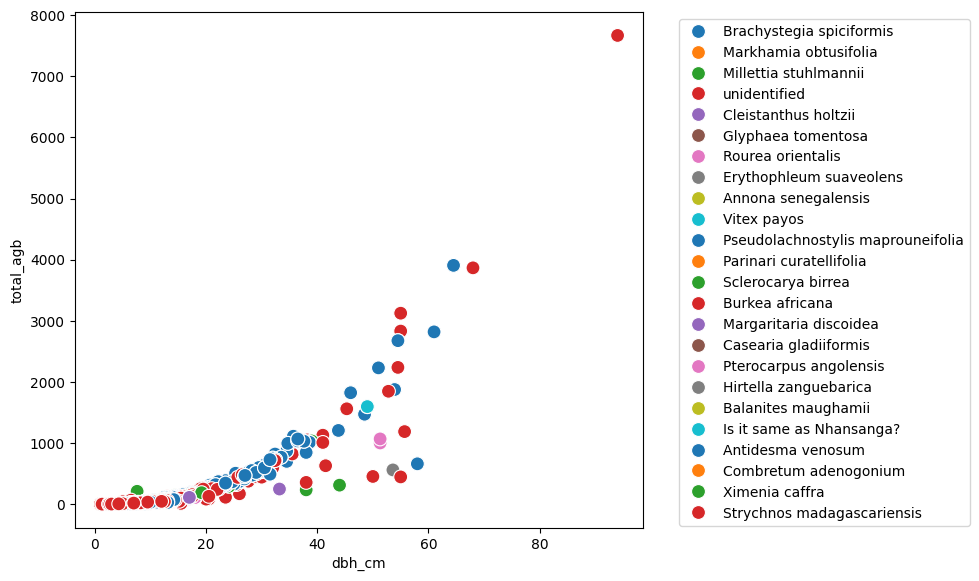

In [14]:
# Create the scatter plot, coloring by the 'group' column
import matplotlib.pyplot as plt
import seaborn as sns

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=tree_df, x='dbh_cm', y='total_agb', hue='scientific_name', palette='tab10', s=100)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Move legend outside
plt.tight_layout()
plt.show()

Overall it looks pretty good. We see some outliers in the ~35-60 cm diameter classes, we could be individuals with broken tops or erroneous total height measurements, or simply trees experiencing stunted height growth. Encouragingly, there is no apparent bias within individual species, which suggests that the model performs reasonably well for both the dominant timber species and the subdominant tree and large shrub species present in the inventory data.

*Calculating plot-level total aboveground biomass*

Now we can summarize these predictions to the plot level (biomass/ha) and then join to the plot locations table we derived earlier. I will also calculate plot-level standard errors and coefficient of variation, both for reporting purposes and so we can understand the variability of the inventory data.

In [15]:
tree_df['total_agb_mt'] = tree_df['total_agb'] * 0.001 #Convert from kg to metric tons
tree_df["total_agb_ha"] = tree_df["total_agb_mt"] * tree_df["expansion_factor_ha"] #Expand to per hectare basis

agb_plot = tree_df.groupby(['concession_id', 'plot_id', 'plot_id_unq'])['total_agb_ha'].agg(['sum', 'std', 'count'])
agb_plot = agb_plot.reset_index()

# Check if 'plot_id' column exists before dropping it
if 'plot_id' in plot_gdf.columns:
    plot_gdf.drop(columns=['plot_id'], inplace=True) #Just drop the original plot_id value from this table now, to avoid redundant columns.

agb_plot_merge = pd.merge(agb_plot, plot_gdf, on=['concession_id', 'plot_id_unq'], how='left')

#Do some renaming
agb_plot_merge = agb_plot_merge.rename(columns={'sum': 'total_agb_ha', 'count': 'n_stems_plot'}) # Corrected: use agb_plot_merge not df

#Calculate standard error
agb_plot_merge['se'] = agb_plot_merge['std'] / np.sqrt(agb_plot_merge['n_stems_plot'])
agb_plot_merge['cov'] = agb_plot_merge['se'] / agb_plot_merge['total_agb_ha']

print(agb_plot_merge)

   concession_id                         plot_id plot_id_unq  total_agb_ha  \
0             LF                           LF_01       ID_36     40.784738   
1             LF                           LF_02       ID_37     10.471699   
2             LF                           LF_03       ID_38     14.980533   
3             LF                           LF_04       ID_39    398.739343   
4             LF                           LF_05       ID_40     18.251540   
5             LF                           LF_06       ID_41     17.148603   
6             LF                           LF_07       ID_42    207.701009   
7             LF                           LF_08       ID_43     93.095945   
8             LF                          LF_08R       ID_44     33.777338   
9             LF                           LF_09       ID_45     73.076738   
10            LF                           LF_10       ID_46     44.643673   
11            LF                           LF_11       ID_47    

##Part III: Post-stratifying the inventory plots

Now we are ready to generate areal estimates of aboveground biomass for the two concessions. I am going to demonstrate how to do this by post-stratifying the available plot data, a technique that I have found useful for adding predictive power to non-uniform inventory datasets in other forest types.

The same caveats that I outlined for stem-level biomass models apply here as well: This demonstration will proceed with a single model of concession biomass, though in practice I would consider multiple formulations, explore the impact of continuous predictors, etc.

The modeling workflow will proceed as follows:


1.   Process imagery: download some imagery to work with and develop a stratification layer.
2.   Develop and fit the model: I will develop a hierarchical model that accounts for partial-pooling of variances among concessions and strata.  I will fit the model in Stan, a widely used platform for Bayesian inference.
3. Generate and summarize posterior predictions for the two concessions: Lastly, we will use these models to generate posterior distributions of total aboveground biomass for the two concessions, then summarize these into median estimates and associated uncertainty assessments.

*Stratifying the project area*

To stratify the project area and plot inventory samples, we will access Google's [satellite embeddings dataset](https://developers.google.com/earth-engine/tutorials/community/satellite-embedding-01-introduction) and use these data to perform a clustering analysis. This product aggregates input data from multiple sensors, across calendar years, and collapses this information into a discrete set of 'embeddings' that represent differences in physical and phenological structure across the landscape.

To start, I will pull in the embeddings image collection, clip it to the project area, and visualize a few bands of the data.

In [16]:
embeddings_collection = ee.ImageCollection("GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL").filterDate('2025-01-01', '2025-12-31').mosaic()

embeddings = embeddings_collection.clip(bounds_ee)

vis_params_rgb = {
    'min': -0.3,
    'max': 0.3,
    'bands': ['A10', 'A30', 'A60'] # Pick a few bands to explore, you can change these for additional EDA.
}

img_map = geemap.Map()
img_map.centerObject(bounds_ee, zoom = 9)
img_map.add_basemap("HYBRID")
img_map.add_layer(embeddings, vis_params_rgb, "2025 embeddings")
img_map.add_layer(bounds_ee, {}, "Concession bounds")
img_map.add_layer(plot_loc_ee, {}, "Sampling plots")
img_map

Map(center=[-18.887040535302553, 35.0502820401025], controls=(WidgetControl(options=['position', 'transparent_…

You can experiment with different band combinations, and explore the imagery dataset. I see that the embeddings data is picking up differences in canopy density, as well as capturing disturbances and topographical effects.

We could now use some or all of the 64 embeddings as direct predictors of biomass. I'm a little wary of doing that here, because of the distribution of the plot data. Instead, let's look at using the embeddings to define some clusters, then explore whether these would be useful for post stratification.

The next chunk trains a k-Means clustering algorithm to the embeddings for the full project area, and generates a stratification layer. I am also pulling in the JAXA/ALOS 2020 forest/non-forest classification, which we can use as a point of reference to assess the quality of the stratification.

In [17]:
n_clusters = 4 #Define number of clusters; keep it small since we have a small plot sample
n_samples = 1000 #Number of samples from the embeddings rasters to train clusterer

#Sample the raster to build a training dataset
training = embeddings.sample(**{
    'region': bounds_ee,
    'scale': 30,  #Native resolution of the embeddings is 10m, but we will scale up given 14x14m plot size.
    'numPixels' : n_samples,
    'seed': 100})

clusterer = ee.Clusterer.wekaKMeans(n_clusters).train(training) #k-Means clustering

clustered_embeddings = embeddings.cluster(clusterer)

#Get the JAXA layer and clip to the project area
fnf_dataset = ee.ImageCollection('JAXA/ALOS/PALSAR/YEARLY/FNF4').filterDate('2020-01-01', '2020-12-31').first()

fnf_image = fnf_dataset.select('fnf')

fnf_clip = fnf_image.clip(bounds_ee)

#Define visualization parameters for FNF layer
fnf_vis_params = {
    'min': 1,
    'max': 4,
    'palette': ['#006400', '#228B22', '#FFBB22', '#0000FF'] # Dark Green, Forest Green, Orange, Blue
}

# Define visualization parameters for the clustered image
cluster_vis_params = {
    'min': 0,
    'max': n_clusters - 1,
    'palette': ['red', 'green', 'blue', 'yellow'], # Example palette for 5 clusters
    'scale': 100 # Add a coarser scale for display to prevent timeouts
}

cluster_map = geemap.Map()
cluster_map.centerObject(bounds_ee, zoom = 9)
cluster_map.add_basemap("HYBRID")
cluster_map.add_layer(fnf_clip, fnf_vis_params, "JAXA FNF")
cluster_map.add_ee_layer(clustered_embeddings, cluster_vis_params, "clustered embeddings")
cluster_map.add_layer(bounds_ee, {}, "Concession bounds")
cluster_map.add_layer(plot_loc_ee, {}, "Sampling plots")
cluster_map


Map(center=[-18.887040535302553, 35.0502820401025], controls=(WidgetControl(options=['position', 'transparent_…

You can compare the clustered layer to the JAXA forest/non-forest map, continuous embeddings, and baseline satellite imagery. Overall I'm satisfied with the way it's capturing structure over the landscape. Cluster 0 (red) looks to correspond with denser, closed canopy forest while cluster 1 (blue) and cluster 2 (green) seem to capture open woodlands and transitional areas. Cluster 3 (yellow) is doing a good job of capturing non-forested areas. Across the full project extent cluster 4 looks to be combining both natural & anthropogenic features, along with what looks to be large expanses of savanna across the southern region. Increasing the number of clusters, and/or using supervised classification, would help here. But, given the small plot sample, increasing the number of clusters will affect our ability to generate a robust stratification.

A few other methodological notes:

*   I chose to stratify the full project extent, rather than just the concessions of interest, on the assumption that future plot data will be collected. We will want a consistent stratification layer to best use all available data for biomass prediction.
*   In an applied context, I would incorporate some ground truth points to train and validate the classification model. Input from field crews would be invaluable here.
* For uncertainty quantification, we could use fuzzy clustering via sklearn or another probabilistic algorithm, then propagate these errors into statistical model predictions. This would require some development but is likely worth exploring.

For now, though, let's move forward with this classification. We'll extract the cluster values to the sample plot locations and assess their distribution in the sampling data.





In [20]:
# Convert the plot locations with biomass data into an Earth Engine FeatureCollection
agb_plot_gdf = gpd.GeoDataFrame(agb_plot_merge, geometry='geometry')
agb_plot_ee = geemap.gdf_to_ee(agb_plot_gdf)

cluster_values = clustered_embeddings.reduceRegions(
    collection=agb_plot_ee,
    reducer=ee.Reducer.first(),
    scale=30
)

agb_plot_stratified = ee.data.computeFeatures({
    'expression': cluster_values,
    'fileFormat': 'PANDAS_DATAFRAME'
})

#Note at this point I discovered 3 MPM plots that have corrupted coordinate values.
#This could be a problem with the input data or my parsing of the excel sheets.
#At any rate, it's a small number of plots so let's just drop them for the demo.
agb_plot_stratified = agb_plot_stratified.rename(columns={'first': 'cluster_id'})
agb_plot_stratified = agb_plot_stratified.dropna(subset=['cluster_id'])

cluster_counts = agb_plot_stratified.groupby(['concession_id', 'cluster_id']).size()
print(cluster_counts)

concession_id  cluster_id
LF             0.0            4
               1.0           10
               2.0           10
MPM            0.0           22
               1.0            2
               2.0            8
dtype: int64


We have decent distribution across clusters 0, 1, and 2. As expected, we don't have any plots in cluster 3 (non-forest). Given that our classification does a good job capturing the non-forested areas this is expected.

##Part IV: Modeling mean aboveground biomass for each concession

**Fitting a hierarchical biomass model**

Now we will use our plot biomass estimates and this statification layer to predict mean total aboveground biomass for each concession.

Note that some combinations of concession x cluster have quite low sample sizes. One of the advantages of hierarchical modeling over a classic stratified estimator is that it makes it easy to partially pool variances, essentially "borrowing strength" from stratum with more plots to stabilize estimates of those with fewer. As we'll see below, this approach does tend to pull group-level estimates towards a global mean, which may or may not be desirable.

Without much prior knowledge on these two concessions, I will assume that we expect the plots to arrive from a similar data generating process, and construct a hierarchical model that allows for partial pooling of variances across different combinations of `concession_id` and `cluster_id`.

To fit the model, we will call Stan using the pystan interface. The first step is defining the model.

In [21]:
#This is our model
#It defines group means for the two concessions x three clusters
#Non-centered parameterization provides faster/more stable sampling of HMC algorithm
#Using standard/weakly informative priors on the parameters but these could be informed with other data too

#Stan models can sometimes hit errors when compiled more than once in a session, this avoids that.
import nest_asyncio
nest_asyncio.apply()

model_code = """
data {
  int<lower=1> N;                   // Total observations
  int<lower=1> N_concession_level;  // Number of unique concessions (main groups)
  int<lower=1> N_cluster_level;     // Number of unique clusters (sub-groups, e.g., 0, 1, 2)
  int<lower=1> N_strata;            // Number of unique (concession, cluster) combinations that appear in data

  array[N] int<lower=1, upper=N_strata> stratum_obs_idx;   // Stratum ID for each observation

  // Mappings from stratum_idx to its corresponding concession and cluster ID
  array[N_strata] int<lower=1, upper=N_concession_level> concession_for_stratum_idx;
  array[N_strata] int<lower=1, upper=N_cluster_level> cluster_for_stratum_idx;

  vector[N] y;                      // biomass estimates for each observation
}

parameters {
  // Population-level mean
  real mu_global;

  // Non-centered hierarchical parameters for concession effects
  vector[N_concession_level] z_concession;
  real<lower=0> sigma_concession;

  // Non-centered hierarchical parameters for cluster effects
  vector[N_cluster_level] z_cluster;
  real<lower=0> sigma_cluster;

  real<lower=0> sigma_y;         // SD of observations within a stratum
}

transformed parameters {
  // Expected mean for each concession (hierarchical)
  vector[N_concession_level] mu_concession = mu_global + z_concession * sigma_concession;

  // Expected additive effect for each cluster (hierarchical)
  vector[N_cluster_level] mu_cluster_effect = z_cluster * sigma_cluster;

  // Mean for each of the N_strata combinations (additive effects)
  vector[N_strata] mu_strata_predicted;
  for (s in 1:N_strata) {
    mu_strata_predicted[s] = mu_concession[concession_for_stratum_idx[s]] + mu_cluster_effect[cluster_for_stratum_idx[s]];
  }
}

model {
  // Priors (Weakly informative)
  mu_global ~ normal(0, 10);
  sigma_concession ~ normal(0, 5);
  sigma_cluster ~ normal(0, 5);
  sigma_y ~ normal(0, 5);

  // Non-centered standard normal for z components
  z_concession ~ std_normal();
  z_cluster ~ std_normal();

  // Likelihood
  for (n in 1:N) {
    y[n] ~ normal(mu_strata_predicted[stratum_obs_idx[n]], sigma_y);
  }
}

generated quantities {
  // Use this block to generate mu_strata_predicted for a new concession x cluster combination such as:
  //vector[N_strata] mu_strata_predicted;
  //for (s in 1:N_strata) {
  //  mu_strata_predicted[s] = mu_concession[concession_for_stratum_idx[s]] + mu_cluster_effect[cluster_for_stratum_idx[s]];
}
"""


#Prep the data to pass to Stan
N = len(agb_plot_stratified)
y = agb_plot_stratified['total_agb_ha'].values

# Create 1-based integer IDs for concessions
concession_names = agb_plot_stratified['concession_id'].unique()
N_concession_level = len(concession_names)
concession_id_map = {name: i + 1 for i, name in enumerate(concession_names)}

# Create 1-based integer IDs for clusters
cluster_ids_raw = agb_plot_stratified['cluster_id'].unique()
N_cluster_level = len(cluster_ids_raw)
cluster_id_map = {cid: int(cid) + 1 for cid in cluster_ids_raw}

# Create a combined 'stratum_id' based on unique concession-cluster pairs
strata_df_prep = agb_plot_stratified[['concession_id', 'cluster_id']].drop_duplicates().reset_index(drop=True)
strata_df_prep['concession_cluster_key'] = strata_df_prep['concession_id'].astype(str) + '_' + strata_df_prep['cluster_id'].astype(str)

unique_strata_keys = strata_df_prep['concession_cluster_key'].unique()
N_strata = len(unique_strata_keys)
stratum_id_map = {key: i + 1 for i, key in enumerate(unique_strata_keys)}

# stratum_obs_idx: N length array, mapping each observation to its stratum index
stratum_obs_idx = (agb_plot_stratified['concession_id'].astype(str) + '_' + agb_plot_stratified['cluster_id'].astype(str)).map(stratum_id_map).values

# Prepare mappings for each stratum to its concession and cluster IDs
strata_df_prep['stratum_idx_stan'] = strata_df_prep['concession_cluster_key'].map(stratum_id_map)
strata_df_prep['concession_id_stan'] = strata_df_prep['concession_id'].map(concession_id_map)
strata_df_prep['cluster_id_stan'] = strata_df_prep['cluster_id'].map(cluster_id_map)

# Sort by stratum_idx_stan to ensure correct array order for Stan
strata_df_prep = strata_df_prep.sort_values(by='stratum_idx_stan')

concession_for_stratum_idx = strata_df_prep['concession_id_stan'].values
cluster_for_stratum_idx = strata_df_prep['cluster_id_stan'].values


stan_data = {
    "N": N,
    "N_concession_level": N_concession_level,
    "N_cluster_level": N_cluster_level,
    "N_strata": N_strata,
    "stratum_obs_idx": stratum_obs_idx,
    "concession_for_stratum_idx": concession_for_stratum_idx,
    "cluster_for_stratum_idx": cluster_for_stratum_idx,
    "y": y
}

# 3. Build (compile) the model
posterior = stan.build(model_code, data=stan_data)


Building...



Building: 49.8s, done.

In the above, we define the model we pass to Stan as a text string, format the data into the format Stan expects, then compile the model by calling `stan.build`. The model itself is fit to the plot-level biomass estimates as strata means `mu_strata_predicted` which themselves are defined by a global intercept and additive effects of concessions and clusters. The strata effects are given a common, normally-distributed prior, implying that we expect biomass estimates across concessions and clusters to be related (i.e., the partial pooling). Lastly model parameters are given weakly informative priors.

Now let's sample from the stan model. We'll produce 40,000 posterior draws which should be sufficient to get good model convergence even with the small sample sizes in some of the strata.

In [22]:
fit = posterior.sample(num_chains=4, num_samples=10000)

Sampling:   0%
Sampling:   0% (100/44000)
Sampling:   1% (300/44000)
Sampling:  25% (11200/44000)
Sampling:  50% (22000/44000)
Sampling:  75% (33000/44000)
Sampling: 100% (44000/44000)
Sampling: 100% (44000/44000), done.
Messages received during sampling:
  Gradient evaluation took 8.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.87 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/tmp/httpstan_fj5bf323/model_5hm4htz5.stan', line 59, column 4 to column 68)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Gradient evaluation took 5.6e-05 seconds
  1000 transitions usin

You'll notice some warnings related to sampler efficiency during the warmup phase, but these do resolve as we begin to sample. If we had some prior information, particularly on structural differences between the two concessions, incorporating this into the parameter prior distributions would probably help here. It could also be a sign that partial-pooling is inappropriate for these data. In a practical context I would look at introducing some other model formulations, but overall what we have is sufficient.

Let's have a look at some diagnostic plots to inspect model convergence more closely.

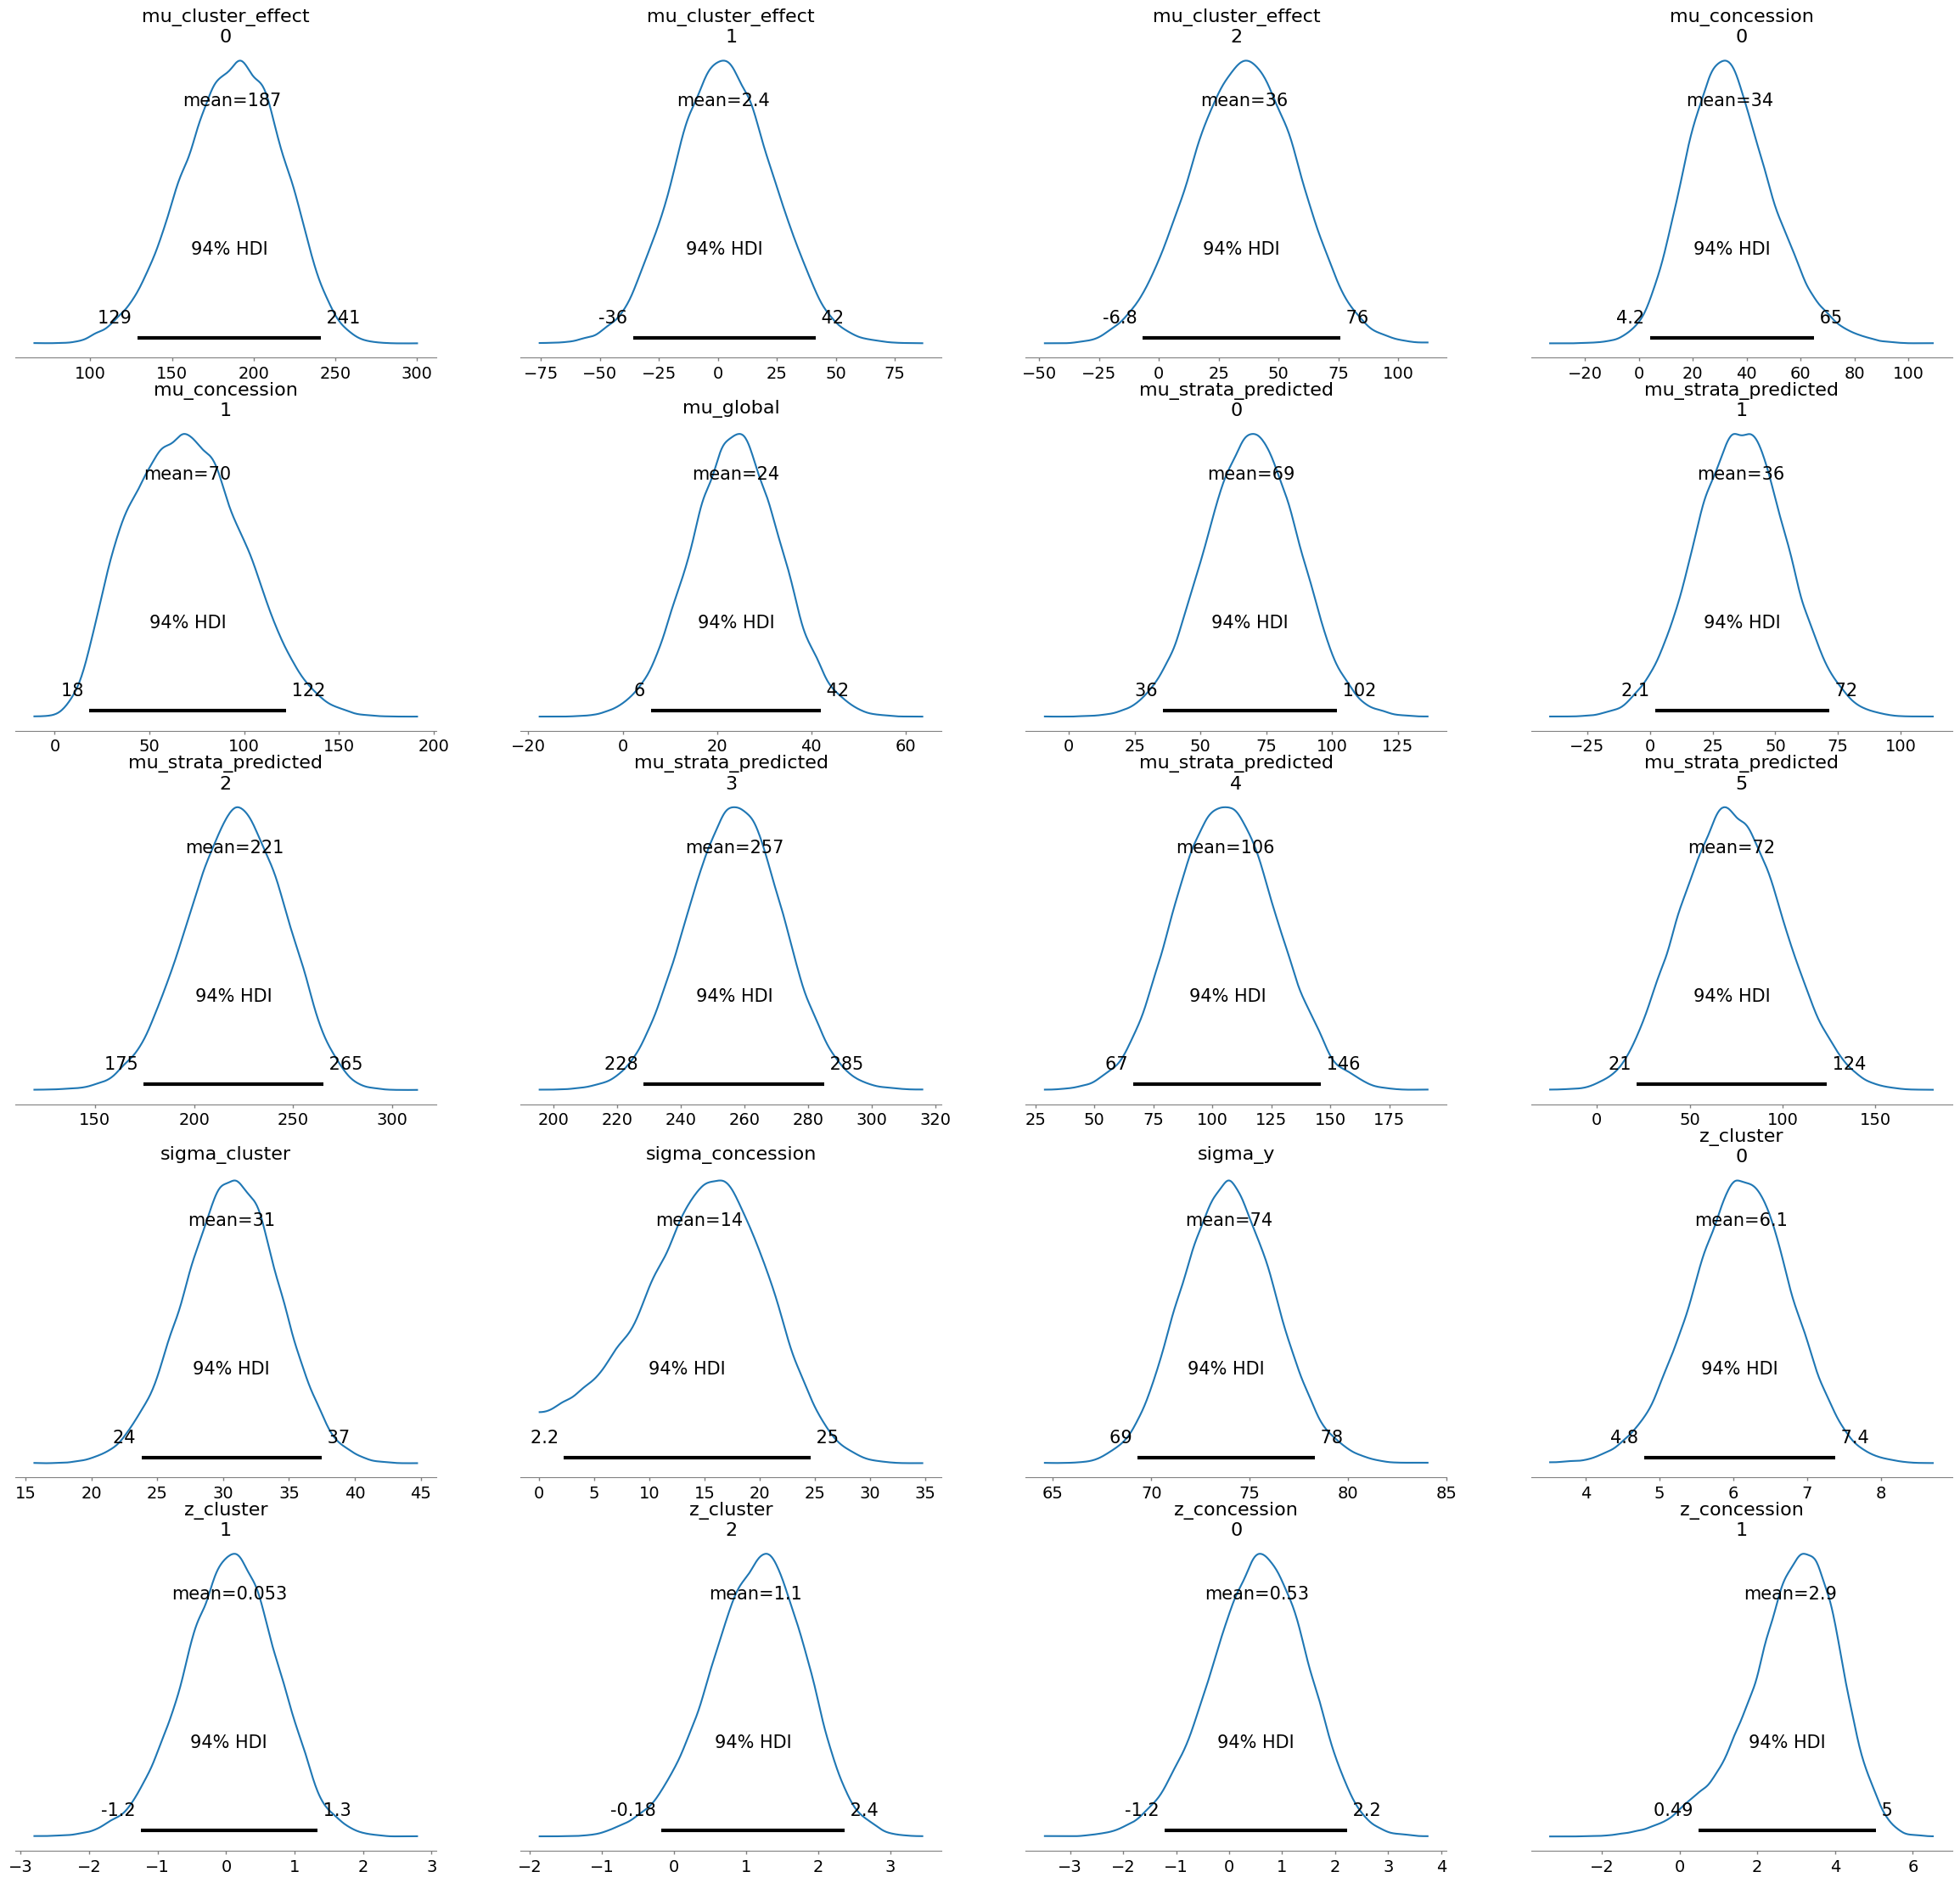

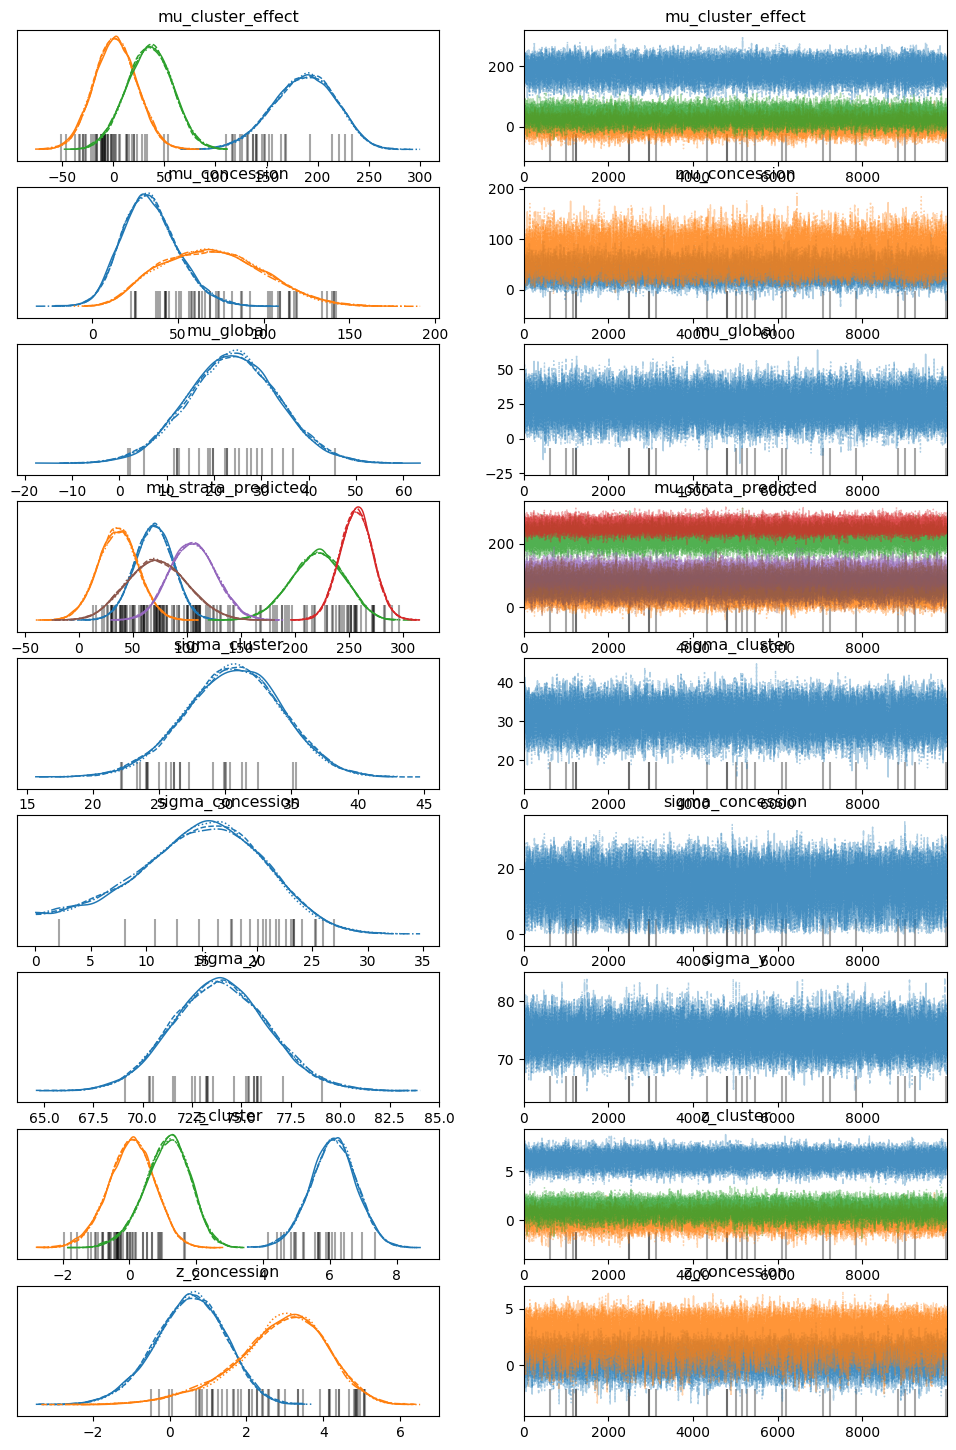

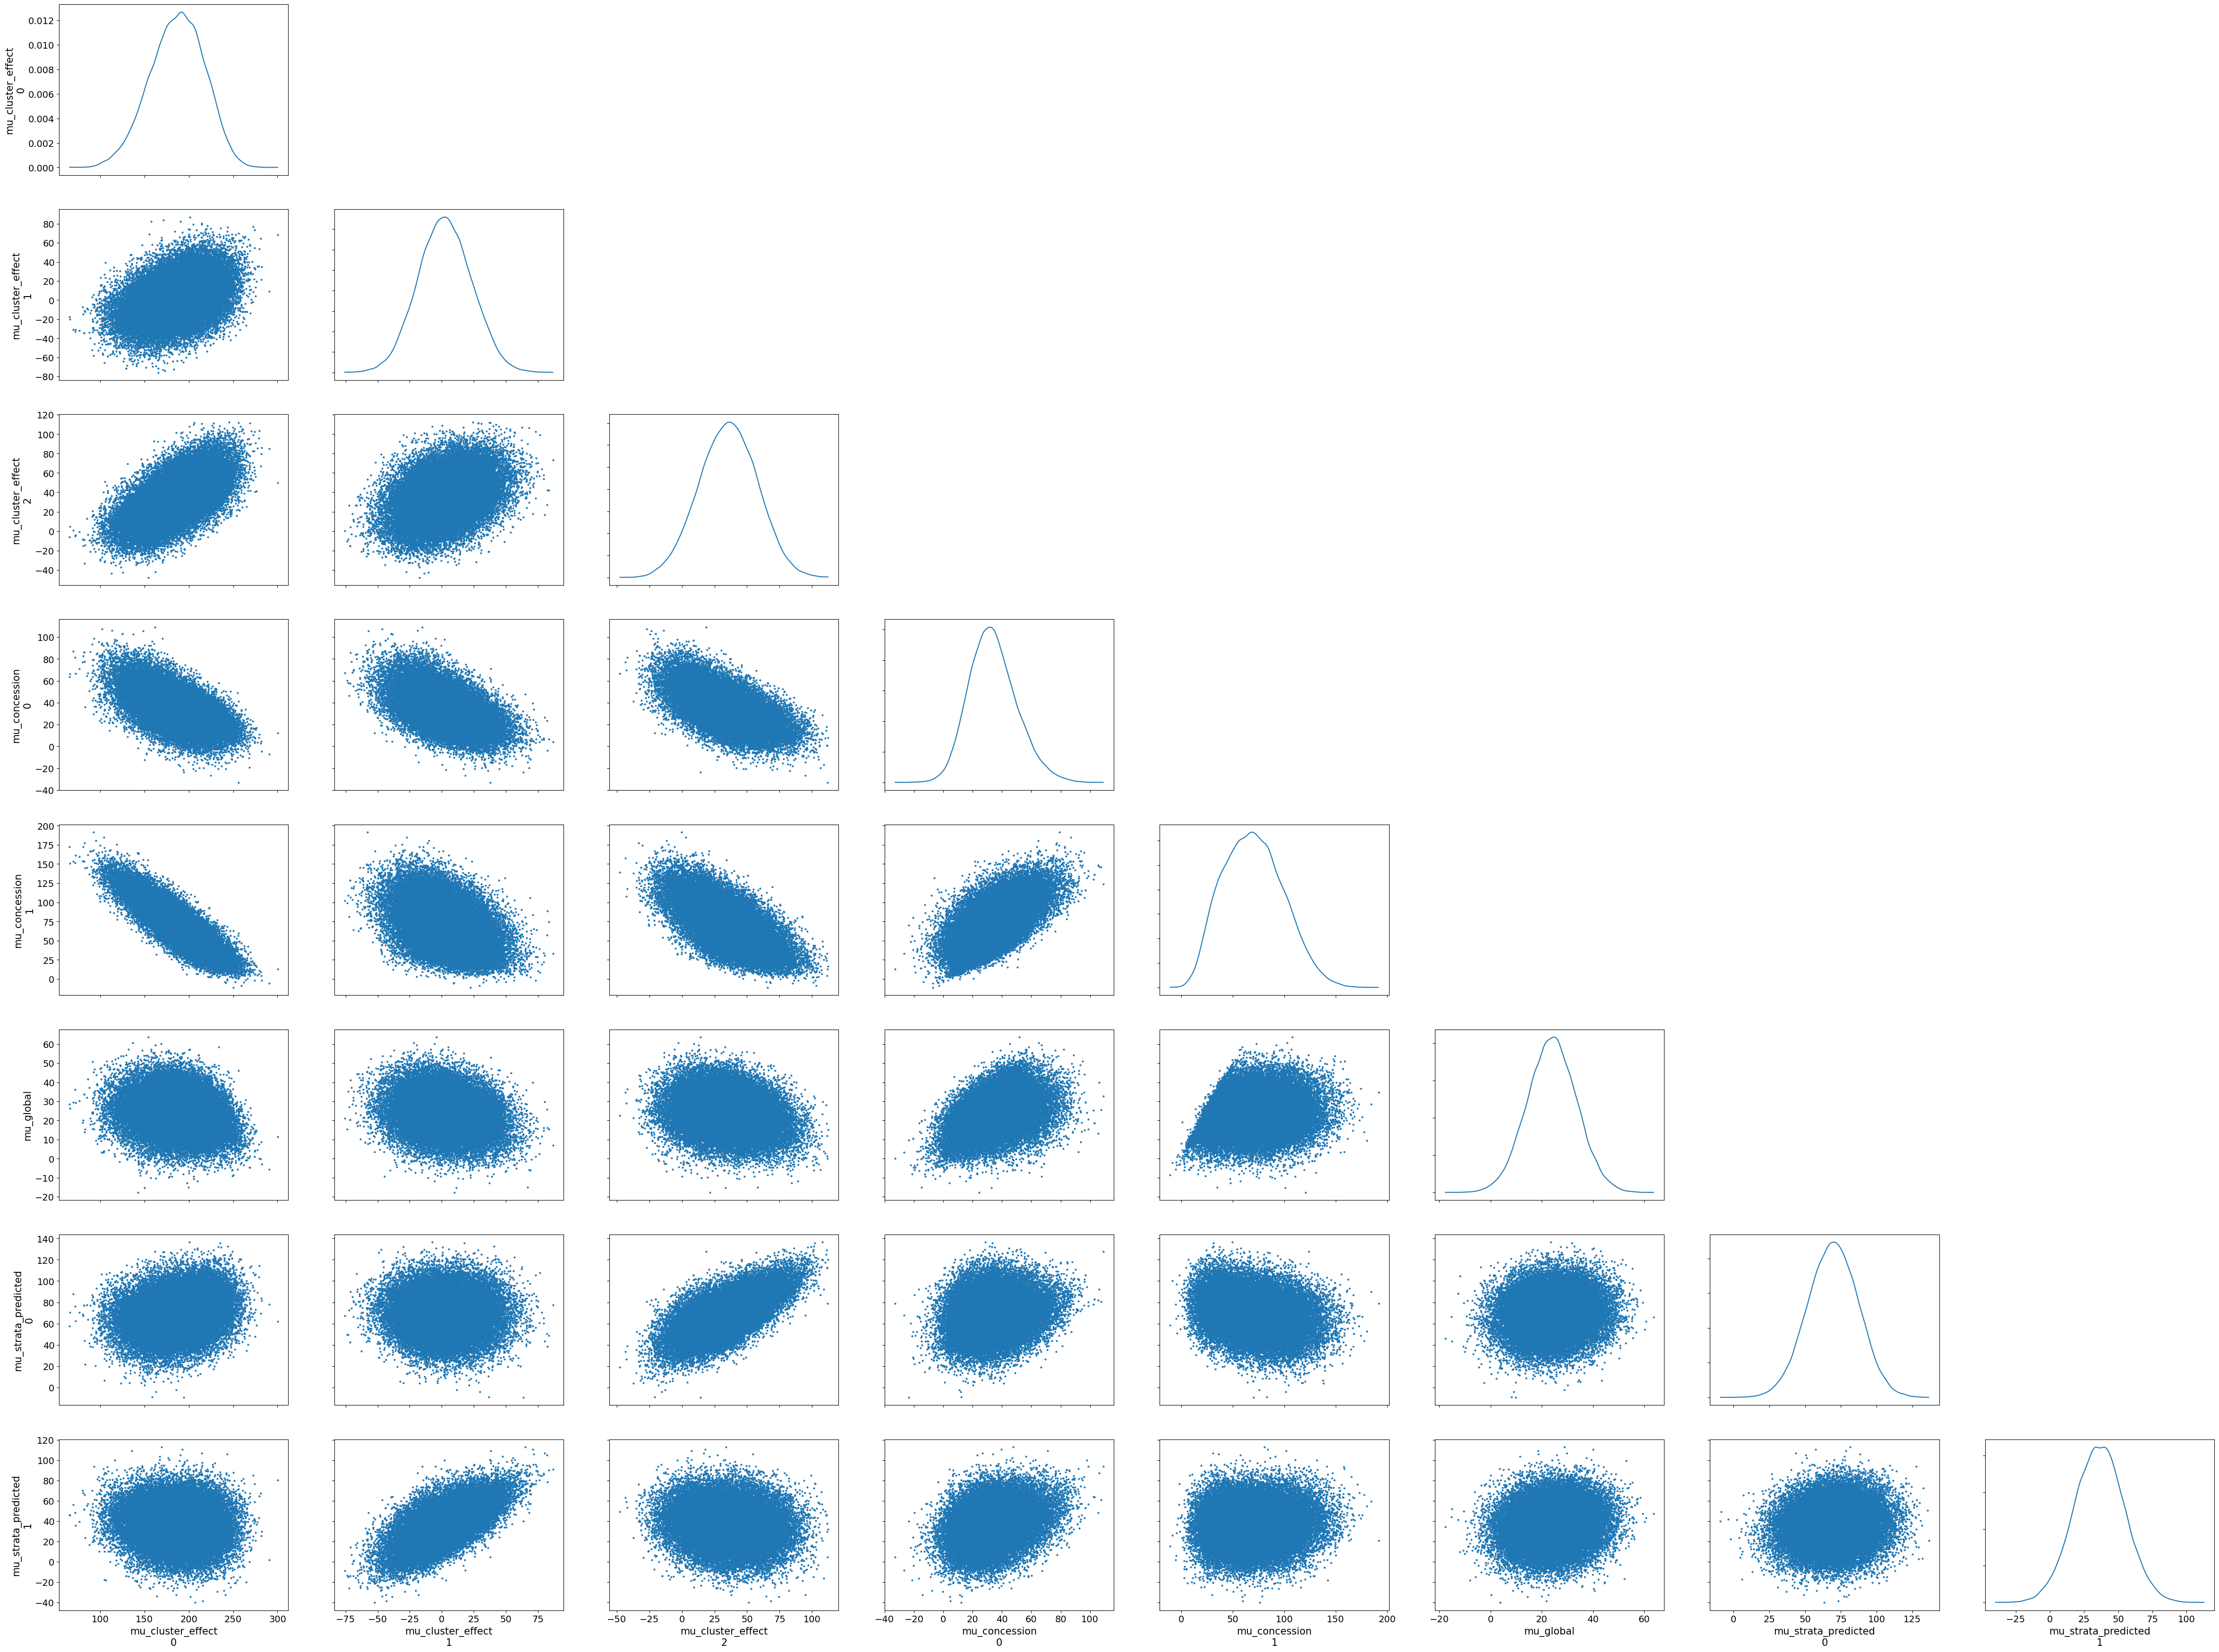

In [23]:
import arviz as az
import matplotlib.pyplot as plt

idata = az.from_pystan(fit)

#Posterior densities
az.plot_posterior(idata)
plt.show()


#Trace plots for HMC sampler
az.plot_trace(idata)
plt.show()

#Pairwise joint distributions
az.plot_pair(idata, marginals=True)
plt.show()

Overall it looks pretty good. There are some parameters that show a fairly high degree of correlation with each other, which probably accounts for the somewhat poorer sampler efficiency, but there's no sign of divergence and the posterior samples are well-formed.

**Calculating total biomass and uncertainty for the two concessions**

The `mu_strata_predicted` values represent posterior draws for each concession x stratum combination. With the way this model is constructed, we need to summarize these to get our mean total biomass estimates for each concession.

The next code chunk will pull the posterior draws for the strata then operate rowwise to calculate posterior draws for each concession.

In [24]:
#First, create a mapping to relate the stratum indices we passed to Stan to the concessions.
strata_to_concession_map = strata_df_prep.set_index('stratum_idx_stan')['concession_id']

# Ensure 'samples' DataFrame is available
samples = fit.to_frame()

#Now we are going to iterate through the posterior draws and compute concession mean for each
#e.g., 40000 draws represented by rows in the following data frame.
concession_posterior_means = pd.DataFrame(index=samples.index)

# Iterate through each unique concession ID
for concession in strata_to_concession_map.unique():
    # Get the stratum_idx_stan values that belong to the current concession
    strata_indices = strata_to_concession_map[strata_to_concession_map == concession].index

    # Select the corresponding mu_strata_predicted columns from the samples
    # Stan parameters are 1-based indexed, so we need to adjust the column names.
    strata_cols = [f'mu_strata_predicted.{idx}' for idx in strata_indices]

    # Calculate the mean across these strata for each posterior draw
    # Ensure that these columns exist in the samples DataFrame
    existing_strata_cols = [col for col in strata_cols if col in samples.columns]
    if existing_strata_cols:
        concession_posterior_means[f'mean_biomass_{concession}'] = samples[existing_strata_cols].mean(axis=1)
    else:
        print(f"Warning: No strata columns found for concession {concession} in samples.")

#Compute and print summary stats
summary_stats = concession_posterior_means.describe(percentiles=[0.025, 0.5, 0.975])
print(summary_stats)

       mean_biomass_LF  mean_biomass_MPM
count     40000.000000      40000.000000
mean        108.747359        144.961639
std          13.884254         16.098066
min          51.377605         89.430319
2.5%         80.859968        115.119275
50%         109.047642        144.626182
97.5%       134.657841        177.276858
max         164.249675        213.486308


For LF, the mean total aboveground biomass per hectare is 108.8 Mt/ha with a 95% credible half-width of about 28 Mt/ha. For MPM it is 144.9 plus or minus ~30 Mt/ha.

Let's look at how these estimates compare to a simple mean from each concession.




                     mean         std  count
concession_id                               
LF              87.358998  134.291878     24
MPM            253.228999  213.519262     35


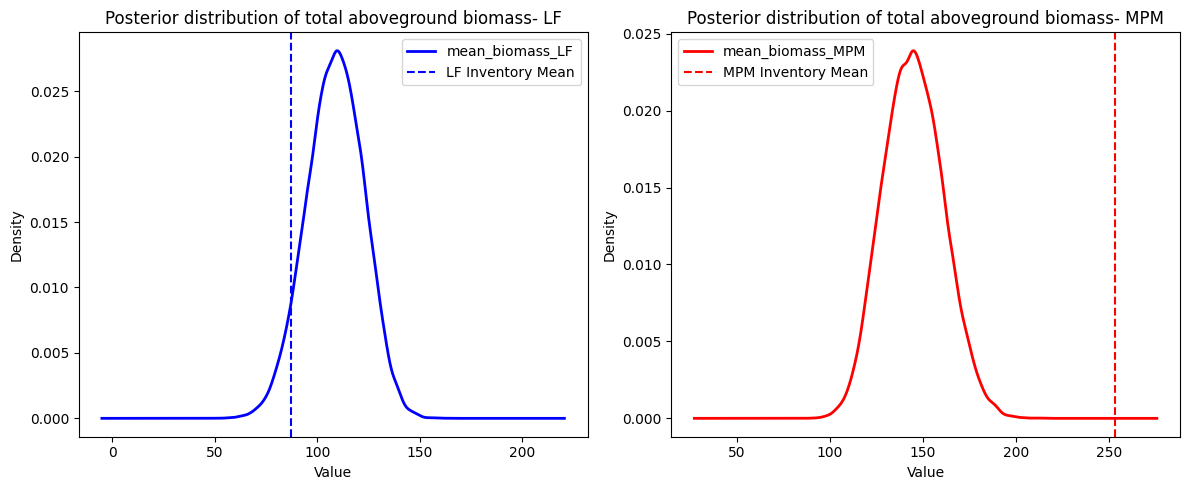

In [25]:
import matplotlib.pyplot as plt

concession_agb_summary = agb_plot_merge.groupby('concession_id')['total_agb_ha'].agg(['mean', 'std', 'count'])
print(concession_agb_summary)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Plot the density of Column_A on the first axis (ax1)
concession_posterior_means['mean_biomass_LF'].plot.kde(ax=ax1, color='blue', linewidth=2)
ax1.set_title('Posterior distribution of total aboveground biomass- LF')
ax1.set_xlabel('Value')
ax1.set_ylabel('Density')
# Add vertical dashed line for LF concession mean from inventory data
ax1.axvline(concession_agb_summary.loc['LF', 'mean'], color='blue', linestyle='--', label='LF Inventory Mean')
ax1.legend()

# Plot the density of Column_B on the second axis (ax2)
concession_posterior_means['mean_biomass_MPM'].plot.kde(ax=ax2, color='red', linewidth=2)
ax2.set_title('Posterior distribution of total aboveground biomass- MPM')
ax2.set_xlabel('Value')
ax2.set_ylabel('Density') # Optional: add if desired for clarity
# Add vertical dashed line for MPM concession mean from inventory data
ax2.axvline(concession_agb_summary.loc['MPM', 'mean'], color='red', linestyle='--', label='MPM Inventory Mean')
ax2.legend()

# Adjust layout to prevent titles/labels from overlapping
plt.tight_layout()

# Display the plots
plt.show()

The posterior mean is somewhat higher for LF and significantly lower for MPM, relative to the plot data. This is the impact of the hierarchical model. Given the quite large standard deviations among plots, particularly for MPM, we are modeling with a fair bit of skepticism regarding the observed means.

Without more specific knowledge about potential differences in forest structure and composition among the concessions, it's hard to say if these estimates are appropriate. If we do have a reason to expect MPM to be carrying more than two times the biomass/ha on average than LF, we could reformulate the model to reflect this, by modeling each concession with separate priors.

To get a bit more insight, let's take a look at some histograms of the plot data.

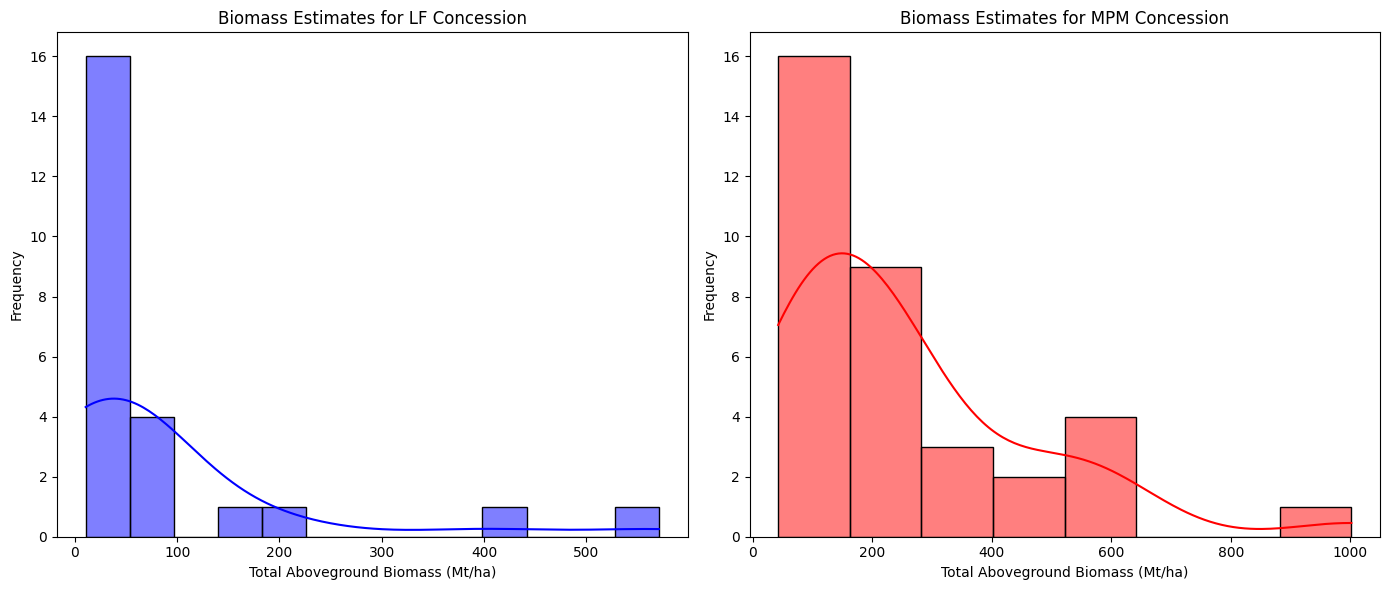

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Histogram for LF concession
sns.histplot(agb_plot_merge[agb_plot_merge['concession_id'] == 'LF']['total_agb_ha'], kde=True, ax=ax1, color='blue')
ax1.set_title('Biomass Estimates for LF Concession')
ax1.set_xlabel('Total Aboveground Biomass (Mt/ha)')
ax1.set_ylabel('Frequency')

# Histogram for MPM concession
sns.histplot(agb_plot_merge[agb_plot_merge['concession_id'] == 'MPM']['total_agb_ha'], kde=True, ax=ax2, color='red')
ax2.set_title('Biomass Estimates for MPM Concession')
ax2.set_xlabel('Total Aboveground Biomass (Mt/ha)')
ax2.set_ylabel('Frequency')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

The MPM inventory data include some quite high measurements, including one plot in excess of 800 Mt/ha, but are heavily left-skewed, like the LF data. I would conclude that the simple observed mean of MPM is being influenced by these outliers, and the posterior mean of the hierarchical model is providing the more reasonable estimate.

Additional plot data may be necessary to have full confidence in these averages, but based on the available information, I would recommend using the posterior means from the hierarchical model rather than the summary means from the inventory data.

##Part V: Recommendations and next steps
Based on these results, I make the following recommendations to improve biomass esimates for the Mozambique project:

**Collect additional inventory plots**

Above all, the disagreement between the sampling means and posterior means, plus the high variance of the inventory data, indicates that additional sampling will likely have a strong positive impact on our analysis. The stratification layer we produced, and the initial mean estimates we developed, can be used to lay out an efficient sample design that incorporates the challenges and limitations of conducting inventory in this ecosystem. I do not think a large number of additional plots will be necessary; a small additional sample to improve power in some of the strata would help a lot.

Note we can also use this model to predict strata-level biomass for the other concessions in the project, by modifying the `generated quantities` block in the Stan model. These estimates would not be suitable for inference, but could be the basis for designing a sparse sampling strategy that makes the best use of available resources. Depending on how similar the concessions are to one another, it may not be necessary to inventory all of them.

**Consider additional candidate models**

In this demonstration, I fit one hierarchical model of posterior means. We could consider additional regression models that incorporate the satellite embeddings or other imagery as continuous predictors. These could improve our predictive power and would facilitate fine scale mapping of biomass across the landscape.

**Improve the stratification layer**

In the demo example, I produced an unsupervised classification of the landscape. Ideally, we would incorporate local/exert knowledge and have the ability to do some additional groundtruthing across the site. This could also improve our sampling, such as by incorporating additional information on specific forest types.

**Model additional carbon pools**

The basic workflow presented here can be extended to incorporate allometry of belowground biomass, or even sub-models of additional carbon pools such as soil carbon.

##Acknowledgements
Thank you very much for reading, and for considering me for the role of Global Carbon Modeling Manager with Imperative Global.

If you have any questions about the work, or issues executing the notebook, please reach out to bclough84@gmail.com.



##Data export
The remaining chunks generate the various demo outputs and save to drive.

In [55]:
###Output data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [56]:
import os

output_folder = '/content/drive/MyDrive/Mozambique_Biomass_Analysis_Output'

# Create the directory if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    print(f"Output folder '{output_folder}' created.")
else:
    print(f"Output folder '{output_folder}' already exists.")


Output folder '/content/drive/MyDrive/Mozambique_Biomass_Analysis_Output' created.


In [57]:
dataframes_to_save = {
    'tree_df': tree_df,
    'agb_plot_merge': agb_plot_merge,
    'strata_df_prep': strata_df_prep,
    'summary_stats': summary_stats,
    'concession_agb_summary': concession_agb_summary,
    'concession_posterior_means': concession_posterior_means
}

for df_name, df_object in dataframes_to_save.items():
    file_path = os.path.join(output_folder, f'{df_name}.csv')
    df_object.to_csv(file_path, index=False)
    print(f"DataFrame '{df_name}' saved to '{file_path}'")

DataFrame 'tree_df' saved to '/content/drive/MyDrive/Mozambique_Biomass_Analysis_Output/tree_df.csv'
DataFrame 'agb_plot_merge' saved to '/content/drive/MyDrive/Mozambique_Biomass_Analysis_Output/agb_plot_merge.csv'
DataFrame 'strata_df_prep' saved to '/content/drive/MyDrive/Mozambique_Biomass_Analysis_Output/strata_df_prep.csv'
DataFrame 'summary_stats' saved to '/content/drive/MyDrive/Mozambique_Biomass_Analysis_Output/summary_stats.csv'
DataFrame 'concession_agb_summary' saved to '/content/drive/MyDrive/Mozambique_Biomass_Analysis_Output/concession_agb_summary.csv'
DataFrame 'concession_posterior_means' saved to '/content/drive/MyDrive/Mozambique_Biomass_Analysis_Output/concession_posterior_means.csv'


In [59]:
file_path = os.path.join(output_folder, 'summary_stats.csv')
summary_stats.to_csv(file_path, index=False)
print(f"DataFrame 'summary_stats' saved to '{file_path}'")

DataFrame 'summary_stats' saved to '/content/drive/MyDrive/Mozambique_Biomass_Analysis_Output/summary_stats.csv'


In [60]:
file_path = os.path.join(output_folder, 'concession_agb_summary.csv')
concession_agb_summary.to_csv(file_path, index=False)
print(f"DataFrame 'concession_agb_summary' saved to '{file_path}'")

DataFrame 'concession_agb_summary' saved to '/content/drive/MyDrive/Mozambique_Biomass_Analysis_Output/concession_agb_summary.csv'


Scatter plot saved to '/content/drive/MyDrive/Mozambique_Biomass_Analysis_Output/dbh_vs_agb_scatter.png'


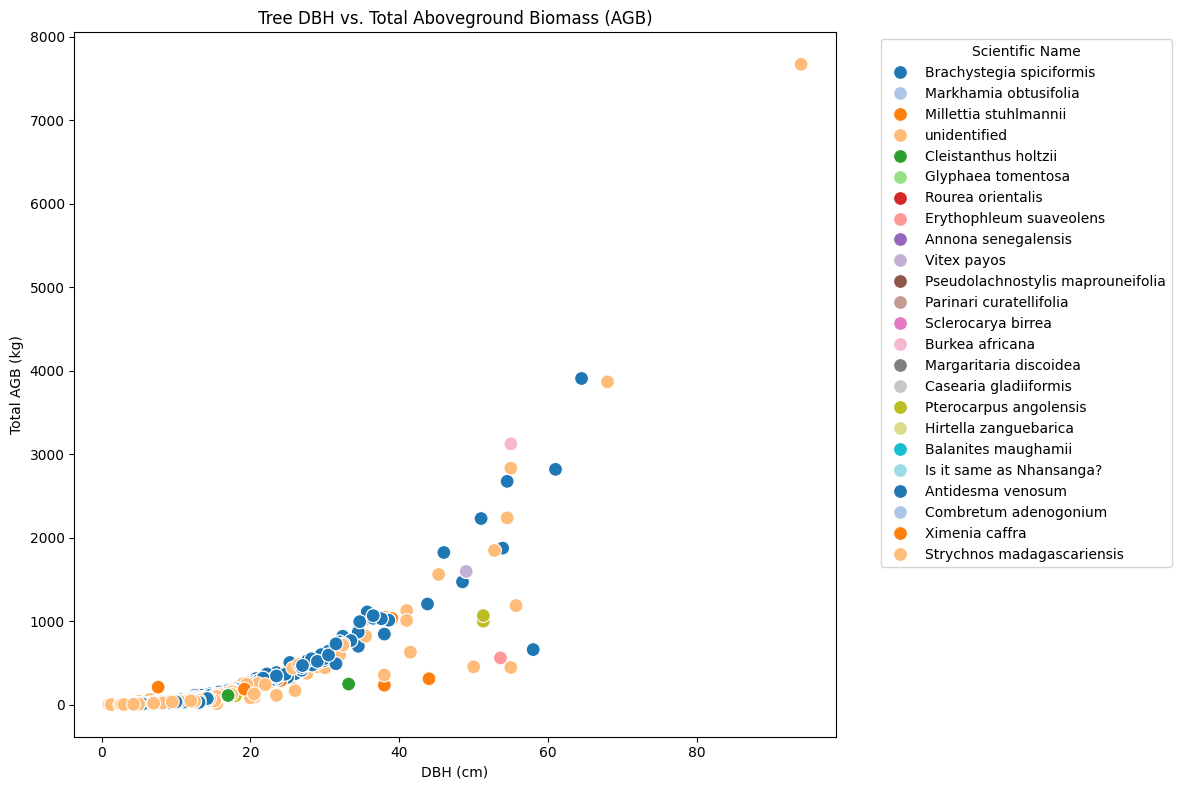

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Ensure output_folder is defined. It was defined in a previous cell.
# output_folder = '/content/drive/MyDrive/Mozambique_Biomass_Analysis_Output'

# 1. Create a scatter plot of dbh_cm versus total_agb
plt.figure(figsize=(12, 8))
sns.scatterplot(data=tree_df, x='dbh_cm', y='total_agb', hue='scientific_name', palette='tab20', s=100)
plt.title('Tree DBH vs. Total Aboveground Biomass (AGB)')
plt.xlabel('DBH (cm)')
plt.ylabel('Total AGB (kg)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Scientific Name')
plt.tight_layout()
file_path = os.path.join(output_folder, 'dbh_vs_agb_scatter.png')
plt.savefig(file_path, dpi=300)
print(f"Scatter plot saved to '{file_path}'")
plt.show()

Density plot saved to '/content/drive/MyDrive/Mozambique_Biomass_Analysis_Output/posterior_vs_inventory_density.png'


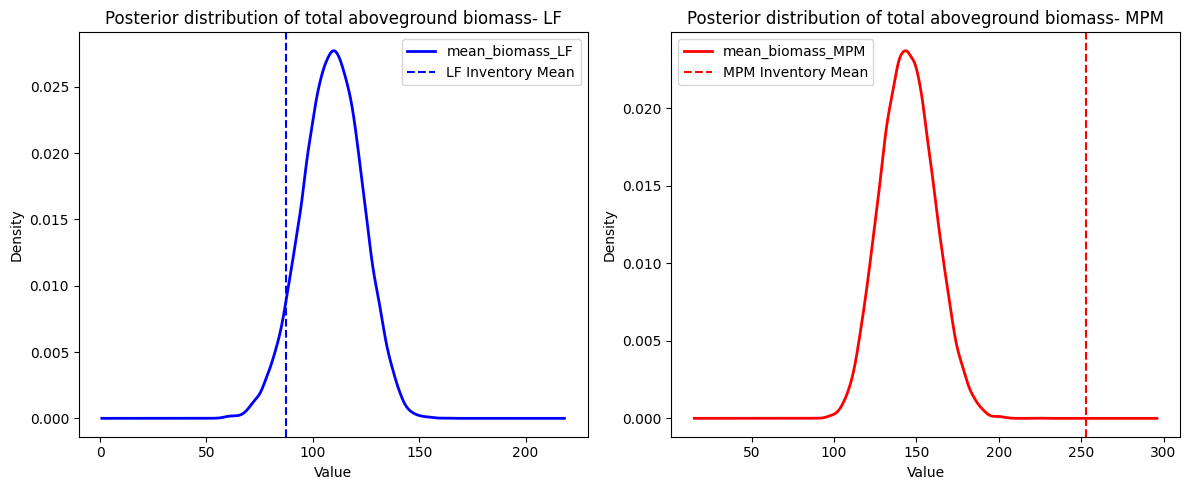

In [62]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Plot the density of Column_A on the first axis (ax1)
concession_posterior_means['mean_biomass_LF'].plot.kde(ax=ax1, color='blue', linewidth=2)
ax1.set_title('Posterior distribution of total aboveground biomass- LF')
ax1.set_xlabel('Value')
ax1.set_ylabel('Density')
# Add vertical dashed line for LF concession mean from inventory data
ax1.axvline(concession_agb_summary.loc['LF', 'mean'], color='blue', linestyle='--', label='LF Inventory Mean')
ax1.legend()

# Plot the density of Column_B on the second axis (ax2)
concession_posterior_means['mean_biomass_MPM'].plot.kde(ax=ax2, color='red', linewidth=2)
ax2.set_title('Posterior distribution of total aboveground biomass- MPM')
ax2.set_xlabel('Value')
ax2.set_ylabel('Density') # Optional: add if desired for clarity
# Add vertical dashed line for MPM concession mean from inventory data
ax2.axvline(concession_agb_summary.loc['MPM', 'mean'], color='red', linestyle='--', label='MPM Inventory Mean')
ax2.legend()

# Adjust layout to prevent titles/labels from overlapping
plt.tight_layout()
file_path = os.path.join(output_folder, 'posterior_vs_inventory_density.png')
plt.savefig(file_path, dpi=300)
print(f"Density plot saved to '{file_path}'")
plt.show()

Histogram plot saved to '/content/drive/MyDrive/Mozambique_Biomass_Analysis_Output/plot_biomass_histograms.png'


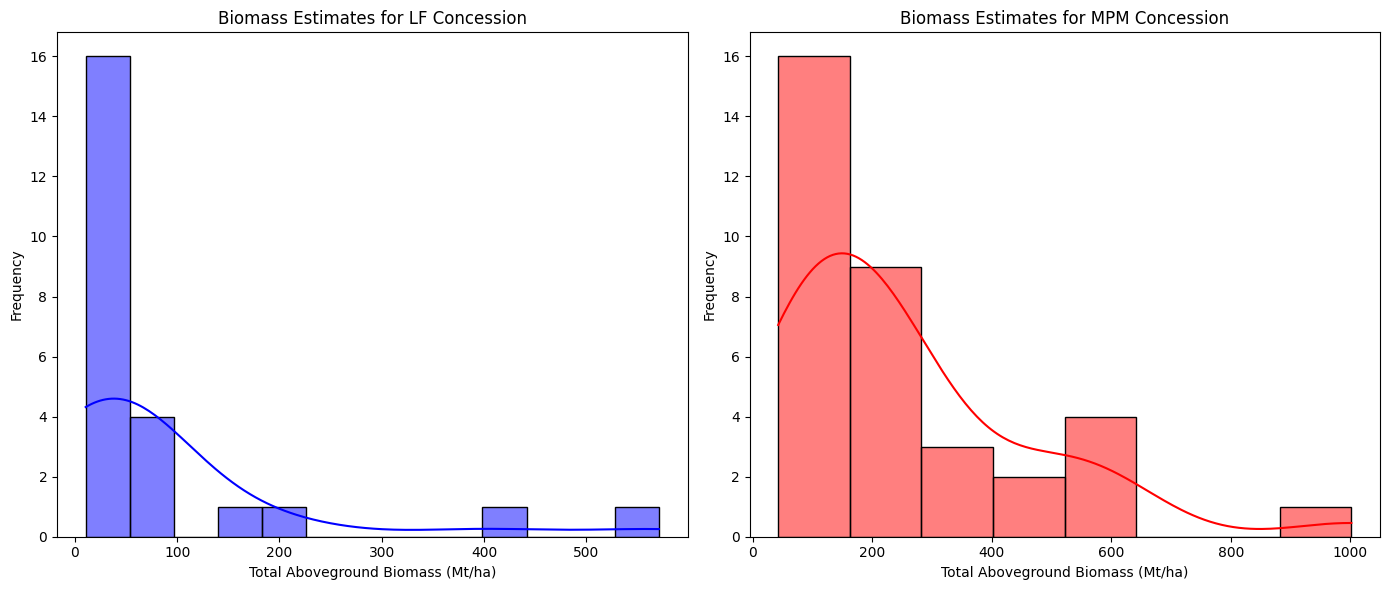

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Histogram for LF concession
sns.histplot(agb_plot_merge[agb_plot_merge['concession_id'] == 'LF']['total_agb_ha'], kde=True, ax=ax1, color='blue')
ax1.set_title('Biomass Estimates for LF Concession')
ax1.set_xlabel('Total Aboveground Biomass (Mt/ha)')
ax1.set_ylabel('Frequency')

# Histogram for MPM concession
sns.histplot(agb_plot_merge[agb_plot_merge['concession_id'] == 'MPM']['total_agb_ha'], kde=True, ax=ax2, color='red')
ax2.set_title('Biomass Estimates for MPM Concession')
ax2.set_xlabel('Total Aboveground Biomass (Mt/ha)')
ax2.set_ylabel('Frequency')

# Adjust layout and display the plot
plt.tight_layout()
file_path = os.path.join(output_folder, 'plot_biomass_histograms.png')
plt.savefig(file_path, dpi=300)
print(f"Histogram plot saved to '{file_path}'")
plt.show()

In [27]:
import ee

# Define the output folder in your Google Drive
drive_output_folder = 'Mozambique_Biomass_Analysis_Output'

# Define export parameters
export_params = {
    'image': clustered_embeddings,
    'description': 'Clustered_Embeddings_Export',
    'folder': drive_output_folder,
    'fileNamePrefix': 'clustered_embeddings',
    'scale': 30, # Resolution of the output image in meters
    'maxPixels': 1e13 # Increase maxPixels for larger areas if needed
}

# Start the export task
task = ee.batch.Export.image.toDrive(**export_params)
task.start()

print(f"Earth Engine export task 'Clustered_Embeddings_Export' started. Monitor its progress in the GEE Tasks tab (https://code.earthengine.google.com/tasks).")

Earth Engine export task 'Clustered_Embeddings_Export' started. Monitor its progress in the GEE Tasks tab (https://code.earthengine.google.com/tasks).
